In [1]:
# required Python imports
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

from scipy.spatial.transform import Rotation as r

In [2]:
# define some neccesary funtions
def sph2cart(phi, theta, T):
    """ Convert from spherical/polar (phi, thetha) to cartesian
    coordinates.

    Parameters
    ----------
    phi : int or float between 0 and pi/2
        angle respect to the c-axis in radians
    theta : int or float between 0 and 2*pi
        angle respect to the a-axis in radians
    T : int or float
        the magnitud of the vector (rho) in polar coordinates

    Returns
    -------
    numpy ndarrays (1d)
        three numpy 1d arrays with the x, y, and z coordinates
    """
    
    x = T * np.sin(phi) * np.cos(theta)
    y = T * np.sin(phi) * np.sin(theta)
    z = T * np.cos(phi)
    
    return x, y, z


def Tvalues(trans, phi, theta):
    """ Calculates the transmission value for any direction in polar
    coordinates using the equation (5) of Asimov et al. (2006) for a
    especific wavelength ignoring the sample thickness (i.e. =1).

    Parameters
    ----------
    trans : a tuple of size 3
        tuple containeing the transmission values along a-axis (Ta),
        b-axis (Tb), and c-axis (Tc). -> (Ta, Tb, Tc)
    phi : int or float between 0 and pi/2
        angle respect to the c-axis in radians
    theta : int or float between 0 and 2*pi
        angle respect to the a-axis in radians

    Returns
    -------
    numpy array
        the calculated T values for any given orientation
    """

    # extract Tx values
    Ta, Tb, Tc = trans
    
    return Ta * np.cos(theta)**2 * np.sin(phi)**2 + \
           Tb * np.sin(theta)**2 * np.sin(phi)**2 + \
           Tc * np.cos(phi)**2

def rotate(coordinates, euler_ang):
    """ Rotate points in 3D cartesian space using the Bunge convention
    in degrees with intrinsic rotation. This is just a wrapper for the
    r.from_euler() Scipy method for convenience

    Parameters
    ----------
    coordinates : tuple of size 3
        a tuple containing the cartesian coordinates of this form:
        (x, y, z). variables x, y and z can be scalars or arrays.
    euler_ang : tuple of size 3
        a tuple containing the three euler angles in degrees
        using Bunge convention -> (z, x, z)

    Returns
    -------
    three numpy arrays containing the x, y, z coordinates respectively
    
    Example
    -------
    x, y, z = rotate(coordinates=(x, y, z), euler_ang=(30, 0, 40))
    """
    # create a ndarray to vectorize the rotation operation
    coordinates = np.dstack(coordinates)

    # define a rotation in euler space (Bunge) for intrinsic rotations
    rotation = r.from_euler('zxz', [euler_ang[0], euler_ang[1], euler_ang[2]], degrees=True)

    # apply rotation
    new_coordinates = coordinates @ rotation.as_matrix().T

    return new_coordinates[:,:,0], new_coordinates[:,:,1], new_coordinates[:,:,2]
    

In [3]:
# generate a mesh of spherical/polar coordinates
theta = np.linspace(0, 2*np.pi, 100)
phi = np.arccos(1 - 2 * np.linspace(0, 1, 100))  # in this case np.linspace goes from 0 to 1 (not pi)!
phi, theta = np.meshgrid(phi, theta)

# estimate T values
T = Tvalues(trans=(90, 50, 20), phi=phi, theta=theta)

# convert from spherical to cartesian coordinates
x, y, z = sph2cart(phi, theta, T)

# normalize colors for T values to max and min values
Tmax, Tmin = T.max(), T.min()
Tcolors = (T - Tmin) / (Tmax - Tmin)

In [4]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
%matplotlib inline

In [5]:
def plot_interactive(phi1, PHI, phi2):
    euler_ang=(phi1, PHI, phi2)
    rotation = rotate(coordinates=(x, y, z), euler_ang=euler_ang)
    fig, axes = plt.subplots(1, 2, figsize=(10, 10), subplot_kw={"projection": "3d"}, constrained_layout=True)

    # first row: rotations around phi 1
    axes[0].plot_surface(rotation[0], rotation[1], rotation[2], rstride=1, cstride=1, facecolors=cm.Spectral_r(Tcolors))
    axes[0].set_xlabel(r'$x$')
    axes[0].set_title('rotated')

    axes[1].contour(rotation[0], rotation[1], rotation[2], [0])
    axes[1].set_title(r'horizontal section')

interact(plot_interactive, phi1 = widgets.FloatSlider(value=0, min=0, max=180, step=10.0),
         PHI = widgets.FloatSlider(value=0, min=0, max=90, step=10.0),
         phi2 = widgets.FloatSlider(value=0, min=0, max=180, step=10.0))

interactive(children=(FloatSlider(value=0.0, description='phi1', max=180.0, step=10.0), FloatSlider(value=0.0,…

<function __main__.plot_interactive(phi1, PHI, phi2)>

In [149]:
def plot_interactive(phi1, PHI, phi2):
    euler_ang=(phi1, PHI, phi2)
    rotation = rotate(coordinates=(x, y, z), euler_ang=euler_ang)
    fig, ax = plt.subplots()

    ax.contour(rotation[0], rotation[1], rotation[2], [0], figsize=(10, 10), constrained_layout=True)
    ax.set_xlim(-100,100)
    ax.set_ylim(-100,100)
    ax.set_aspect('equal', 'box')

    plt.show()

interact(plot_interactive, phi1 = widgets.FloatSlider(value=0, min=0, max=180, step=5.0),
         PHI = widgets.FloatSlider(value=0, min=0, max=90, step=5.0),
         phi2 = widgets.FloatSlider(value=0, min=0, max=180, step=5.0),
                                               )

interactive(children=(FloatSlider(value=0.0, description='phi1', max=180.0, step=5.0), FloatSlider(value=0.0, …

<function __main__.plot_interactive(phi1, PHI, phi2)>

## Minimization Trial using Tmax, Tmin and beta 

I am going to try to get first these values (that i think are unique for a given rotation) and then try to use them to minimize the function

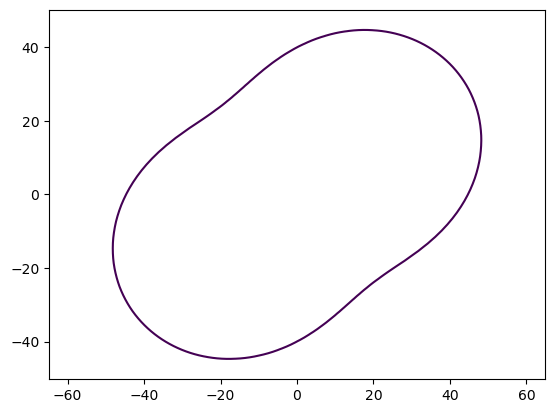

In [153]:
euler_ang=(105, 65, 50)
rotation = rotate(coordinates=(x, y, z), euler_ang=euler_ang)
section_xy = plt.contour(rotation[0], rotation[1], rotation[2], [0])

The following function finds the max, min values of T in the horizontal section and the angle relative to the "East" and the maximum T_section

In [151]:
def parm_section(euler_ang):
    """ section_xy is generated using ax.contour and z = 0, i.e. [0]
    matplotlib.contour.QuadContourSet
    
    section_xy = ax.contour(rotation[0], rotation[1], rotation[2], [0])
    """ 

    rotation = rotate(coordinates=(x, y, z), euler_ang=euler_ang)
    section_xy = plt.contour(rotation[0], rotation[1], rotation[2], [0])

    T_xy = section_xy.allsegs[0]
    T_xy = T_xy[0]
    T_section = np.sqrt(T_xy[:,0]**2 + T_xy[:,1]**2)
    T_section = T_section.round()
    
    index_T = np.where(T_section == T_section.max())
    T_xy[index_T[0],:]
    beta = np.arccos(T_xy[index_T[0][0],0]/T_section.max())
    beta = np.degrees(beta)
    beta
    
    T_section_max = T_section.max()
    T_section_min = T_section.min()
    
    return beta.round(), T_section_max, T_section_min

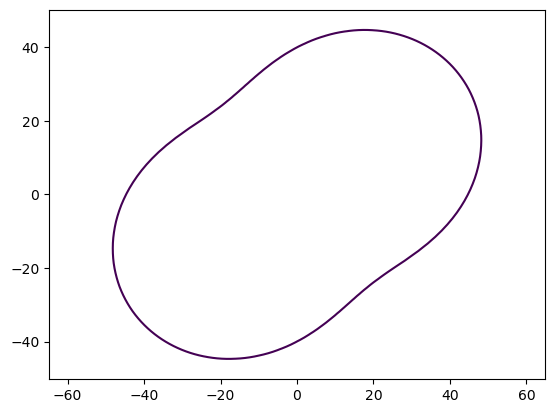

In [156]:
ydata = parm_section(euler_ang)

In [157]:
def g(euler_ang, *ydata):
    return np.sum(ydata - np.array(parm_section(euler_ang)))

In [164]:
from scipy.optimize import minimize

array([105.,  65.,  50.])

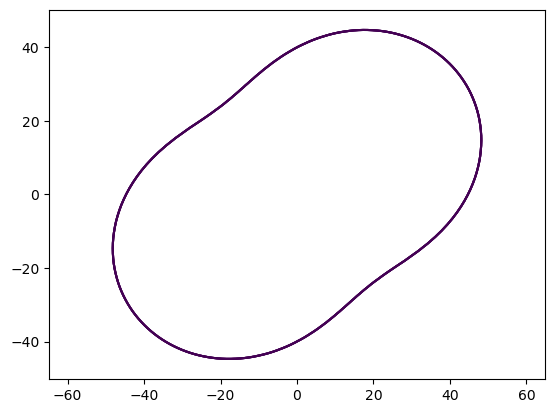

In [165]:
initial_guess = [0, 0, 0]
res = minimize(g, euler_ang, initial_guess)
res.x